### Load and Prepare the Dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')

df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

print(f"Dataset size: {len(df)}")
print(df.head())

Dataset size: 50000
                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


###  Preprocess the Text Data

In [ ]:

VOCAB_SIZE = 10000  
MAX_LEN = 200       
EMBEDDING_DIM = 32  

In [ ]:

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['review'])

In [ ]:

train_sequences = tokenizer.texts_to_sequences(train_df['review'])
test_sequences = tokenizer.texts_to_sequences(test_df['review'])

In [ ]:

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [ ]:

y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (40000, 200)
Test data shape: (10000, 200)


### Build the GRU Model

In [ ]:
model = Sequential([

    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    

    GRU(64, return_sequences=False),  
    

    Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           320000    
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 338881 (1.29 MB)
Trainable params: 338881 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile and Train the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/5


625/625 [==============================] - 77s 118ms/step - loss: 0.6548 - accuracy: 0.5780 - val_loss: 0.5069 - val_accuracy: 0.7995
Epoch 2/5
625/625 [==============================] - 74s 118ms/step - loss: 0.6134 - accuracy: 0.6581 - val_loss: 0.6914 - val_accuracy: 0.5274
Epoch 3/5
625/625 [==============================] - 81s 130ms/step - loss: 0.6693 - accuracy: 0.5763 - val_loss: 0.4379 - val_accuracy: 0.8157
Epoch 4/5
625/625 [==============================] - 77s 123ms/step - loss: 0.3490 - accuracy: 0.8577 - val_loss: 0.3336 - val_accuracy: 0.8604
Epoch 5/5
625/625 [==============================] - 107s 172ms/step - loss: 0.2475 - accuracy: 0.9071 - val_loss: 0.2920 - val_accuracy: 0.8823


### Evaluate and Make Predictions

In [ ]:

loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

313/313 [==============================] - 33s 106ms/step - loss: 0.2920 - accuracy: 0.8823

Test Accuracy: 0.8823


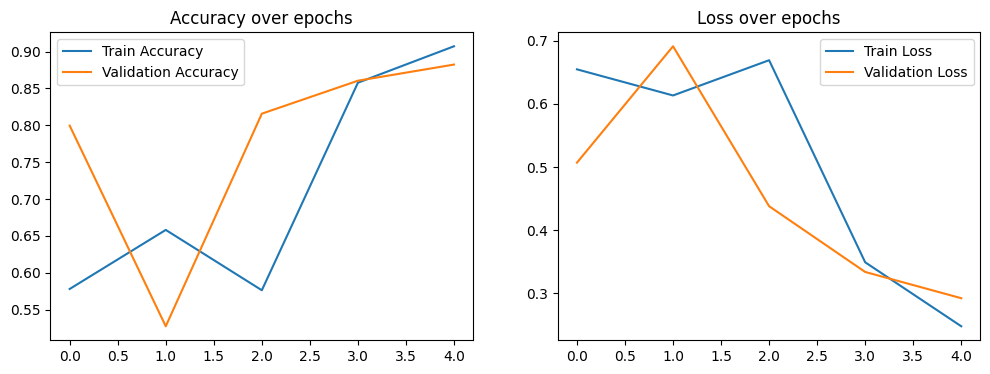

In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [ ]:

sample_texts = test_df['review'].head(3).tolist()
sample_labels = test_df['sentiment'].head(3).tolist()

sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

predictions = model.predict(sample_padded).flatten()
predicted_labels = [1 if p > 0.5 else 0 for p in predictions]

for text, true_label, pred_label, prob in zip(sample_texts, sample_labels, predicted_labels, predictions):
    print(f"\nReview: {text[:200]}...")
    print(f"True Sentiment: {'Positive' if true_label else 'Negative'}")
    print(f"Predicted Sentiment: {'Positive' if pred_label else 'Negative'} (confidence: {prob:.4f})")

1/1 [==============================] - 2s 2s/step

Review: I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ev...
True Sentiment: Positive
Predicted Sentiment: Negative (confidence: 0.0403)

Review: Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you ca...
True Sentiment: Positive
Predicted Sentiment: Positive (confidence: 0.6731)

Review: The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but tha...
True Sentiment: Negative
Predicted Sentiment: Negative (confidence: 0.0105)
